In [34]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler, OneHotEncoder

In [35]:
def import_and_clean_file(file, file_dir):
    # read data from name of file
    sensor, student, activity, activity_subtype, _, date, timestamp = file[:-4].split("_")
    # read in database
    df = pd.read_csv(file_dir)
    # drop features we dont want
    df = df.drop(['ind', 'mag_x','mag_y','mag_z', 'gyro_x','gyro_y','gyro_z'], axis = 1, errors = 'ignore')
    scale_columns = ['accel_x', 'accel_y', 'accel_z']
    df['timestamp'] = df['timestamp'].astype(np.float64)
    df['activity'] = activity
    df['activity_subtype'] = activity_subtype
    df.sort_values(by=['timestamp'])
    # scale data
    
    return df

In [36]:
from scipy import stats

def get_X_y(directory='2023', window_size=50, overlap=25):
    # Initialize lists to store data and labels
    X = []  # Data
    y = []  # Labels

    # Loop through the clean-named subfolders
    for student in os.listdir(directory):
            if "placeholder" not in student:
                student_directory = os.path.join(directory, student)
                # itterate through students data
                for file in os.listdir(student_directory):
                    file_dir = os.path.join(student_directory, file)
                    if os.path.isfile(file_dir) and "clean" in file and "Respeck" in file:
                        sensor, student, activity, activity_subtype, _, date, timestamp = file[:-4].split("_")
                        df = import_and_clean_file(file, file_dir)
                        # Split the time series data into overlapping windows
                        for i in range(0, len(df) - window_size + 1, overlap):
                            window = df[i:i + window_size]
                            # create X matrix
                            X.append(window.drop(columns=['timestamp','activity', 'activity_subtype']))
                            # create y matrix
                            y.append(activity)

    return np.array(X), np.array(y).reshape(-1,1)

In [37]:
X, y = get_X_y('2023')
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(X_train.shape, y_train.shape)

pd.DataFrame(X_train[0]).head()

(3898, 50, 4) (3898, 1)


,0,1,2,3
0,-0.027344,-0.132812,1.001953,0.0
1,-0.038086,-0.131836,1.001953,0.0
2,-0.042969,-0.126953,1.005859,0.0
3,-0.035156,-0.125000,1.010742,0.0
4,-0.035156,-0.129883,0.999023,0.0


In [38]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)
y_train = enc.transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.transform(y_test)


print(X_train.shape, y_train.shape)

(3898, 50, 4) (3898, 12)


In [39]:
def evaluate_1d_cnn(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 50, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = keras.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=6, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    keras.layers.MaxPooling3D
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(100, activation='leaky_relu'))
    model.add(keras.layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1, shuffle=False)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return history, accuracy, model

In [40]:
history, accuracy, model = evaluate_1d_cnn(X_train, y_train, X_val, y_val)
print("Accuracy: " + str(accuracy))

Epoch 1/20
55/55 [==============================] - 9s 93ms/step - loss: 1.3862 - accuracy: 0.5718 - val_loss: 1.0109 - val_accuracy: 0.5923
Epoch 2/20
55/55 [==============================] - 5s 83ms/step - loss: 0.9605 - accuracy: 0.6385 - val_loss: 0.9073 - val_accuracy: 0.6974
Epoch 3/20
55/55 [==============================] - 5s 90ms/step - loss: 0.8638 - accuracy: 0.6668 - val_loss: 0.7997 - val_accuracy: 0.6667
Epoch 4/20
55/55 [==============================] - 4s 75ms/step - loss: 0.8068 - accuracy: 0.6839 - val_loss: 0.7862 - val_accuracy: 0.6692
Epoch 5/20
55/55 [==============================] - 4s 81ms/step - loss: 0.7928 - accuracy: 0.6881 - val_loss: 0.7433 - val_accuracy: 0.7308
Epoch 6/20
55/55 [==============================] - 4s 78ms/step - loss: 0.7975 - accuracy: 0.6910 - val_loss: 0.6921 - val_accuracy: 0.7538
Epoch 7/20
55/55 [==============================] - 5s 85ms/step - loss: 0.7533 - accuracy: 0.7050 - val_loss: 0.7004 - val_accuracy: 0.7333
Epoch 8/20
55

In [20]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/6q/yjm90tjx6td5_1v23jrh5nyc0000gn/T/tmpwhudomw0/assets


INFO:tensorflow:Assets written to: /var/folders/6q/yjm90tjx6td5_1v23jrh5nyc0000gn/T/tmpwhudomw0/assets
2023-10-12 15:18:35.316177: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-10-12 15:18:35.316198: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-10-12 15:18:35.316470: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/6q/yjm90tjx6td5_1v23jrh5nyc0000gn/T/tmpwhudomw0
2023-10-12 15:18:35.317423: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-10-12 15:18:35.317429: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/6q/yjm90tjx6td5_1v23jrh5nyc0000gn/T/tmpwhudomw0
2023-10-12 15:18:35.319500: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-10-12 15:18:35.320613: I tensorflow/cc/saved_model/load

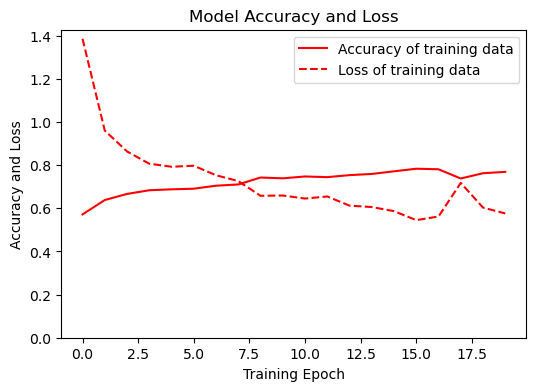

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()



16/16 [==============================] - 1s 19ms/step


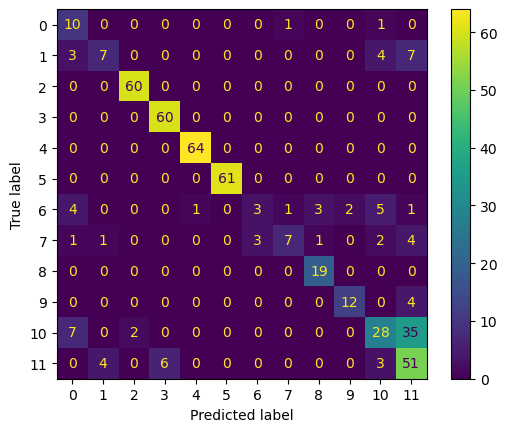

In [42]:
predictions = model.predict(X_val)
predictions = np.argmax(predictions, axis=1)
y_val_pred = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_val_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [43]:
print(classification_report(y_val_pred, predictions))

              precision    recall  f1-score   support

           0       0.40      0.83      0.54        12
           1       0.58      0.33      0.42        21
           2       0.97      1.00      0.98        60
           3       0.91      1.00      0.95        60
           4       0.98      1.00      0.99        64
           5       1.00      1.00      1.00        61
           6       0.50      0.15      0.23        20
           7       0.78      0.37      0.50        19
           8       0.83      1.00      0.90        19
           9       0.86      0.75      0.80        16
          10       0.65      0.39      0.49        72
          11       0.50      0.80      0.61        64

    accuracy                           0.78       488
   macro avg       0.75      0.72      0.70       488
weighted avg       0.79      0.78      0.77       488



In [44]:
model.evaluate(X_val, y_val)

16/16 [==============================] - 0s 20ms/step - loss: 0.5522 - accuracy: 0.7828


[0.5522345900535583, 0.7827869057655334]

In [45]:
[name[3:] for name in enc.get_feature_names_out()]

['Ascending stairs',
 'Descending stairs',
 'Lying down back',
 'Lying down on left',
 'Lying down on stomach',
 'Lying down right',
 'Miscellaneous movements',
 'Normal walking',
 'Running',
 'Shuffle walking',
 'Sitting',
 'Standing']